<h1> <center> Tabular Playground Series - Nov 2021</center></h1>

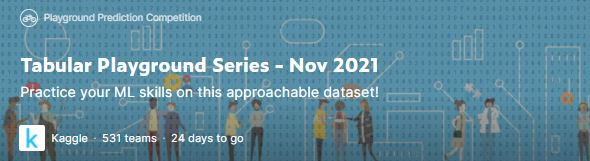

<a id="1"></a>
<h2 style='background:#00bfff; border:0; color:white'><center>Overview</center></h2>
Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, kaggle team have launched many Playground competitions that are more approachable than Featured competitions and thus, more beginner-friendly.

For this competition, we will be predicting a binary target based on a number of feature columns given in the data. ll columns are continuous features .

<h2 style='background:#00bfff; border:0; color:white'><center>About the data</center></h2>

  The data consists of three files :
* train.csv - the training data with the target column
* test.csv - the test set; you will be predicting the target for each row in this file (the probability of the binary target)
* sample_submission.csv - a sample submission file in the correct format

<h2 style='background:#00bfff; border:0; color:white'><center>Notebook Set up</center></h2>

In [ ]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler ,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
print("Packages Imported ")

<h2 style='background:#00bfff; border:0; color:white'><center>Load data</center></h2>

In [ ]:
train_data= pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv')
test_data= pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv')
sample_sub = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv') 
print("Data imported")

<a id="1"></a>
<h2 style='background:#00bfff; border:0; color:white'><center> Simple EDA </center></h2>
Before establishing a baseline , We may first take a look at our dataframes ( train and test ).
<h3> Train data <h3> 

In [ ]:
train_data.head()

In [ ]:
print(f'Number of rows: {train_data.shape[0]};  Number of columns: {train_data.shape[1]}; No of missing values: {sum(train_data.isna().sum())}')

In [ ]:
train_data.describe().style.background_gradient(cmap='coolwarm')

In [ ]:
# variables variaition   
df_var=train_data.var().reset_index()
df_var.columns =['feature', 'variation']
df_var.sort_values("variation",ascending = True)

Some features have very low variation maybe we will consider removing them

#### Correlation matrix 

In [ ]:
# Correlationmatrix
corrMatrix =train_data.corr(method='pearson', min_periods=1)
corrMatrix

#### Correlation with the target 

In [ ]:
cor_targ = train_data.corrwith(train_data["target"]).reset_index()
cor_targ.columns =['feature', 'CorrelatioWithTarget']
cor_targ.sort_values('CorrelatioWithTarget',ascending = False)

#### Target variable
again the target for this competion is also a binary value.

In [ ]:
print('Count of target values:')
countplt, ax = plt.subplots(figsize = (8,5))
ax =sns.countplot(train_data['target'],palette="GnBu_r")

We have a balanced class problem with a little bit ones then zeros xD.

#### Test data 

In [ ]:
test_data.head()

In [ ]:
print(f'Number of rows: {test_data.shape[0]};  Number of columns: {test_data.shape[1]}; No of missing values: {sum(test_data.isna().sum())}')

#### Summarry statistic 

In [ ]:
test_data.describe().style.background_gradient(cmap='YlOrRd')

#### Distribution of Mean and Standard deviation
we want to see the distribution of the mean and standard deviation values per row and column in both train and test data.

In [ ]:
plt.figure(figsize=(15,8))
features = train_data.columns.values[1:101]
sns.distplot(train_data[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_data[features].mean(axis=1),color="darkblue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per row in the train and test data")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train_data[features].mean(axis=0),color="orange",kde=True,bins=120, label='train')
sns.distplot(test_data[features].mean(axis=0),color="blue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per column in the train and test set")
plt.legend()
plt.show()

In [ ]:

plt.figure(figsize=(15,5))
sns.distplot(train_data[features].std(axis=1),color="#2F4F4F", kde=True,bins=120, label='train')
sns.distplot(test_data[features].std(axis=1),color="#FF6347", kde=True,bins=120, label='test')
plt.title("Distribution of std per row in the train and test data ")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train_data[features].std(axis=0),color="#778899",kde=True,bins=120, label='train')
sns.distplot(test_data[features].std(axis=0),color="#800080", kde=True,bins=120, label='test')
plt.title("Distribution of std per column in the train and test data")
plt.legend()
plt.show()

#### Feature Distribution 

In [ ]:
i = 1
plt.figure()
fig, ax = plt.subplots(figsize=(30, 30))
for feature in features:
    plt.subplot(20, 5,i)
    sns.distplot(train_data[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(test_data[feature],color="orange", kde=True,bins=120, label='test')
    i += 1
plt.title("Feature Distribution in train and test data")  
plt.legend()
plt.show()

Looking at this we can say we have similar ( train , test ) data distribution.

<a id="1"></a>
<h2 style='background:#00bfff; border:0; color:white'><center> Establishing Baseline </center></h2>

Now after we did some exploration about the data we start creating our model and then we can iterate . for this problem we are going to use  [Deeptables](https://github.com/DataCanvasIO/DeepTables) which is an is a easy-to-use toolkit that enables deep learning to unleash great power on tabular data.

In [ ]:
### Install packages 
!pip install tensorflow-gpu==2.6.0 deeptables

In [ ]:
# verify installation 
from deeptables.utils.quicktest import test; test()

#### Data preparation 

In [ ]:
y = train_data["target"] # target
used_feat = [ col for col in train_data.columns if col not in ['id','target']]
train= train_data[[*used_feat]]  # train
test = test_data[[*used_feat]] # test 


In [ ]:
# feature enginnering 
#train_data 
train["r_sum"] = train.sum(axis=1)
train["r_skew"] = train.skew(axis=1)
#test_data
test["r_sum"] = test.sum(axis=1)
test["r_skew"] = test.skew(axis=1)

In [ ]:
# data standarization 
scaler = RobustScaler()
train_scal=  scaler.fit_transform(train)
test_scal = scaler.transform(test)

In [ ]:
## import modules 
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.models.deepnets import AutoInt , xDeepFM ,FGCNN ,DeepFM
from deeptables.utils.shap import DeepTablesExplainer
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [ ]:
# define model 
conf = ModelConfig(
 nets=xDeepFM, 
    auto_discrete=False,
    earlystopping_patience =5,
    metrics=['AUC'],
    optimizer= 'Adam') 
dt = DeepTable(config=conf)


In [ ]:
# fit the model 
oof_proba, eval_proba, test_proba = dt.fit_cross_validation(
    train_scal, 
    y,
    X_test=test_scal, 
    num_folds=5,
    batch_size =1024,
    verbose =0,
    stratified= True, 
    epochs=50)

#### Plot Model 

In [ ]:
plot_model(dt.get_model().model,rankdir='TB')

In [ ]:
#check folds leaderboard 
dt.leaderboard.sort_values(by=['val_auc'] ,ascending = False)


### Submission 

In [ ]:
predictions = pd.DataFrame(test_proba) # convert to data frame 
sample_sub["target"]= predictions
sample_sub.to_csv("deeptablesSub.csv",index=False)
sample_sub.head()

<div class="alert alert-success">
  <p><strong>NOTE!</strong> This is just for the demonstration of deeptables for classification problems ,  which i hope you find it usefull , There is always a room for improvement (adjusting the ModelConfig parameter  , feature engineering , feature selection ). i will update this kernal as soon as possible. Happy learning.</p>
</div> 
